# Imports and installations

In [1]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np, tensorflow as tf, pandas as pd
import zipfile, shutil, os, tempfile
import subprocess, sys
from sklearn.model_selection import train_test_split

In [2]:
!pip install pretty_midi librosa numpy matplotlib
!pip install mirdata
# Установите FluidSynth:
# Для Ubuntu/Debian: sudo apt-get install fluidsynth
# Для macOS: brew install fluid-synth
# Для Windows: скачайте с https://www.fluidsynth.org/
!sudo apt install fluidsynth fluid-soundfont-gm

import pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=a8e087574e27d344c7ee41dae9c435ade70d6f452eecd80f5ff2ed29c53baae7
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.4/494.4 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

# Functions

In [3]:
import librosa
import numpy as np

def audio_to_cqt(y, sr=22050, hop_length=512):
    # Константно-квартовая спектрограмма лучше для музыки
    cqt = np.abs(librosa.cqt(y, sr=sr, n_bins=84*2, bins_per_octave=24,
                             hop_length=hop_length))
    # Логарифмируем энергию для лучшего восприятия
    log_cqt = librosa.amplitude_to_db(cqt, ref=np.max)
    # Нормализуем и добавляем ось канала для CNN
    log_cqt = (log_cqt - log_cqt.mean()) / log_cqt.std()
    return log_cqt[..., np.newaxis]  # Форма: [Частоты, Время, 1]

def audio_to_mel(y, sr=22050, hop_length=512):
    # Константно-квартовая спектрограмма лучше для музыки
    mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    # Логарифмируем энергию для лучшего восприятия
    log_cqt = librosa.amplitude_to_db(cqt, ref=np.max)
    # Нормализуем и добавляем ось канала для CNN
    log_cqt = (log_cqt - log_cqt.mean()) / log_cqt.std()
    return log_cqt[..., np.newaxis]  # Форма: [Частоты, Время, 1]

In [60]:
import pretty_midi
import numpy as np

def midi_to_pianoroll(midi_data, times, piano_range=(21, 109)):
    """
    Преобразует MIDI-файл в бинарный пиано-ролл.

    Параметры:
        midi_data: MIDI-данные.
        fs: Частота дискретизации (кадров в секунду). Определяет временное разрешение.
        piano_range: (нижняя_нота, верхняя_нота). (21,109) соответствует 88 клавишам (A0-C8).

    Возвращает:
        raw_roll, pianoroll: numpy array формы (временные_кадры, 88)
    """
    # Создаем "сырой" пиано-ролл с помощью встроенного метода
    # get_piano_roll возвращает матрицу (128 нот x временные_кадры) с velocity
    raw_roll = midi_data.get_piano_roll(times=times)[piano_range[0]:piano_range[1], :]
    # Транспонируем, чтобы время было по оси 0: (время, ноты)
    raw_roll = raw_roll.T
    # Бинаризуем: любое значение > 0 становится 1
    binary_roll = (raw_roll > 0).astype(np.float32)
    # Начала нот
    onset_roll = binary_roll.copy()
    onset_roll[1:] = (raw_roll[1:] > raw_roll[:-1]).astype(np.float32)
    return raw_roll, binary_roll, onset_roll

In [5]:
def midi_to_audio(midi_path, soundfont_path, sr):
        """Рендерит MIDI в аудиофайл WAV с помощью FluidSynth."""
        # Создаем временный WAV-файл
        with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp_wav:
            tmp_path = tmp_wav.name

        # Команда FluidSynth для рендеринга
        command = [
            'fluidsynth', '-ni',
            str(soundfont_path),
            str(midi_path),
            '-F', tmp_path,
            '-r', str(sr),
            '-q'  # Тихий режим
        ]

        # Запускаем рендеринг
        try:
            subprocess.run(command, check=True, capture_output=True)
            # Загружаем сгенерированное аудио
            audio, _ = librosa.load(tmp_path, sr=sr, mono=True)
        finally:
            # Удаляем временный файл
            if os.path.exists(tmp_path):
                os.unlink(tmp_path)

        return audio

# Data

In [48]:
import mirdata
# Инициализируем датасет MAESTRO
maestro = mirdata.initialize('maestro')
# Скачиваем только MIDI и метаданные
maestro.download(partial_download=['midi', 'metadata'])
# maestro.download()

In [49]:
!ls {maestro.data_home}

2004  2009  2014  2018		      maestro-v2.0.0.json
2006  2011  2015  LICENSE	      maestro-v2.0.0-midi.zip
2008  2013  2017  maestro-v2.0.0.csv  README


In [50]:
zip_file_path = f'{maestro.data_home}/maestro-v2.0.0-midi.zip'

In [51]:
# Open the zip file in read mode

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the current directory
    zip_ref.extractall('/content')
    print("Unzipped successfully!")

midi_dir = 'maestro_data'
if os.path.exists(midi_dir):
    shutil.rmtree(midi_dir)
os.makedirs(midi_dir)

dir = '/content/maestro-v2.0.0'
for d in os.listdir(dir):
    if os.path.isdir(f'{dir}/{d}'):
        for f in os.listdir(f'{dir}/{d}'):
            shutil.copy(f'{dir}/{d}/{f}', midi_dir)

shutil.rmtree(dir)

Unzipped successfully!


In [52]:
sr = 16000
hop_length = 1024

In [53]:
max_dur = sr * 10
s_max_dur = librosa.samples_to_frames(max_dur, hop_length=hop_length)

In [54]:
soundfont_path = "/usr/share/sounds/sf2/FluidR3_GM.sf2"

midi_files = os.listdir(midi_dir)
print(midi_files[:3])
midi_files = np.random.choice(midi_files, 20, False)
print(midi_files[:3])
n = len(midi_files)

['MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--3.midi', 'MIDI-Unprocessed_09_R2_2011_MID--AUDIO_R2-D3_04_Track04_wav.midi', 'MIDI-Unprocessed_10_R1_2011_MID--AUDIO_R1-D4_02_Track02_wav.midi']
['MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.midi'
 'MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_06_Track06_wav.midi'
 'ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi']


In [55]:
list(midi_files)

[np.str_('MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.midi'),
 np.str_('MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_06_Track06_wav.midi'),
 np.str_('ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi'),
 np.str_('MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--2.midi'),
 np.str_('MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_03_Track03_wav.midi'),
 np.str_('MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_01_Track01_wav.midi'),
 np.str_('ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--3.midi'),
 np.str_('MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_02_Track02_wav.midi'),
 np.str_('MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_04_Track04_wav.midi'),
 np.str_('MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_04_Track04_wav.midi'),
 np.str_('MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_02_WAV.midi'),
 np.str_('MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp

In [56]:
train_midi = [
    np.str_('MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav.midi'),
    np.str_('MIDI-Unprocessed_15_R1_2009_01-02_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_02_WAV.midi'),
    np.str_('MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav.midi'),
    np.str_('MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--5.midi'),
    np.str_('MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--4.midi'),
    np.str_('MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--1.midi'),
    np.str_('MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--1.midi'),
    np.str_('MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_01_Track01_wav.midi'),
    np.str_('ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--3.midi'),
    np.str_('MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_05_WAV.midi'),
    np.str_('MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.midi'),
    np.str_('MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--2.midi'),
    np.str_('MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi'),
    np.str_('MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.midi'),
    np.str_('MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi'),
    np.str_('MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_02_Track02_wav.midi'),
    np.str_('MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--2.midi'),
    np.str_('MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_05_Track05_wav.midi'),
    np.str_('MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1.midi'),
    np.str_('MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_03_WAV.midi')
]
test_midi = list(filter(lambda x: x not in train_midi, midi_files))
test_midi

[np.str_('MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.midi'),
 np.str_('MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_06_Track06_wav.midi'),
 np.str_('ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi'),
 np.str_('MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--2.midi'),
 np.str_('MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_03_Track03_wav.midi'),
 np.str_('MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_01_Track01_wav.midi'),
 np.str_('ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--3.midi'),
 np.str_('MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_02_Track02_wav.midi'),
 np.str_('MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_04_Track04_wav.midi'),
 np.str_('MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_04_Track04_wav.midi'),
 np.str_('MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_02_WAV.midi'),
 np.str_('MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp

In [57]:
test_midi = [
    np.str_('MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_01_Track01_wav.midi'),
    np.str_('MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.midi'),
    np.str_('MIDI-Unprocessed_23_R2_2011_MID--AUDIO_R2-D6_03_Track03_wav.midi'),
    np.str_('MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav.midi'),
    np.str_('ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.midi'),
    np.str_('MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--6.midi'),
    np.str_('MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_02_Track02_wav.midi'),
    np.str_('MIDI-Unprocessed_10_R2_2008_01-05_ORIG_MID--AUDIO_10_R2_2008_wav--4.midi'),
    np.str_('MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--2.midi'),
    np.str_('MIDI-Unprocessed_XP_03_R1_2004_01-02_ORIG_MID--AUDIO_03_R1_2004_01_Track01_wav.midi'),
    np.str_('MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_02_WAV.midi'),
    np.str_('MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_03_Track03_wav.midi'),
    np.str_('MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--4.midi'),
    np.str_('MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--5.midi'),
    np.str_('MIDI-Unprocessed_Schubert10-12_MID--AUDIO_18_R2_2018_wav.midi'),
    np.str_('MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--3.midi'),
    np.str_('ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--1.midi'),
    np.str_('MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2.midi'),
    np.str_('MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_01_Track01_wav.midi')
]

In [58]:
midi_files = train_midi[:16] + test_midi[:4]

In [62]:
f_names = []
p_rolls_bin = []
p_rolls_ons = []
p_rolls_raw = []
audio = []
cqts = []

for iter, f in enumerate(midi_files):
    sys.stdout.write(f'\r Iteration {iter+1}/{n}')
    sys.stdout.flush()
    midi_path = f'{midi_dir}/{f}'
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    y = midi_to_audio(midi_path, soundfont_path, sr)
    cqt = audio_to_cqt(y, sr=sr, hop_length=hop_length)
    cqt = cqt.reshape(cqt.shape[0], cqt.shape[1]).T
    dur = y.shape[0] / sr

    times = np.linspace(0, dur, cqt.shape[0])
    p_raw, p_bin, p_ons = midi_to_pianoroll(midi_data, times=times)
    p_bin[p_ons == 1] = 2
    f_names.append(f)
    for i in range(0, y.shape[0], max_dur):
        s = librosa.samples_to_frames(i, hop_length=hop_length)
        pr_i = p_raw[s:s+s_max_dur]
        pb_i = p_bin[s:s+s_max_dur]
        po_i = p_ons[s:s+s_max_dur]
        y_i = y[i:i+max_dur]
        cqt_i = cqt[s:s+s_max_dur]
        p_rolls_raw.append(np.pad(pr_i, ((0, s_max_dur-pb_i.shape[0]), (0, 0))))
        p_rolls_bin.append(np.pad(pb_i, ((0, s_max_dur-pb_i.shape[0]), (0, 0))))
        p_rolls_ons.append(np.pad(po_i, ((0, s_max_dur-pb_i.shape[0]), (0, 0))))
        audio.append(np.pad(y_i, (0, max_dur-y_i.shape[0])))
        cqts.append(np.pad(cqt_i, ((0, s_max_dur-pb_i.shape[0]), (0, 0))))
    if iter == 15:
        train_size = len(audio)

 Iteration 20/20

In [63]:
len(audio)

1298

In [64]:
train_size

1016

In [75]:
p_rolls_bin = np.array(p_rolls_bin)
p_rolls_ons = np.array(p_rolls_ons)
# p_rolls_bin /= p_rolls_bin.max()
p_rolls_bin[p_rolls_bin > 0] = 1
audio = np.array(audio)
cqts = np.array(cqts)
p_rolls_bin.shape, p_rolls_ons.shape, audio.shape, cqts.shape

((1298, 156, 88), (1298, 156, 88), (1298, 160000), (1298, 156, 168))

In [76]:
s_max_dur

array(156)

In [ ]:
idx = np.random.randint(len(cqts))

In [80]:
print(idx)

321


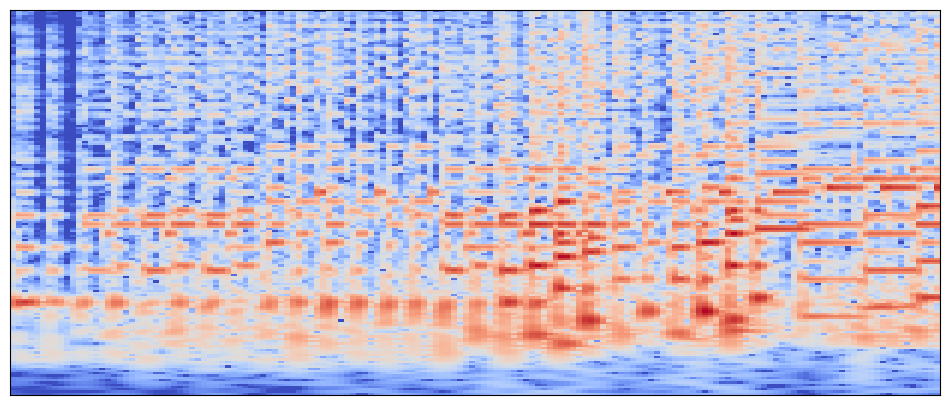

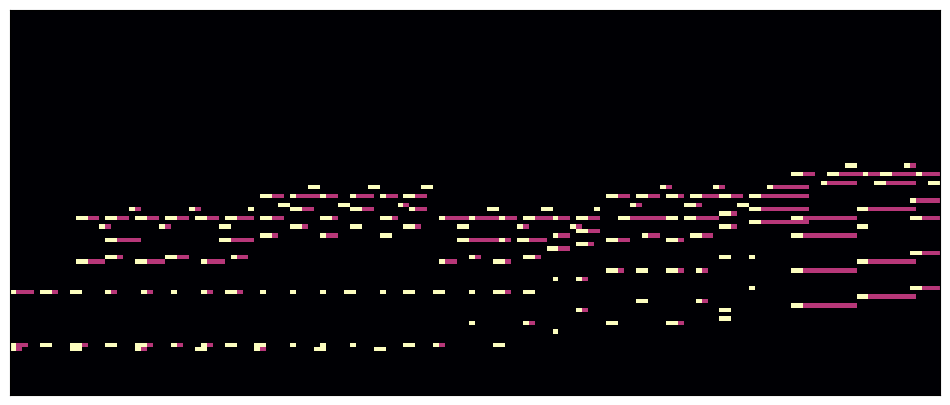

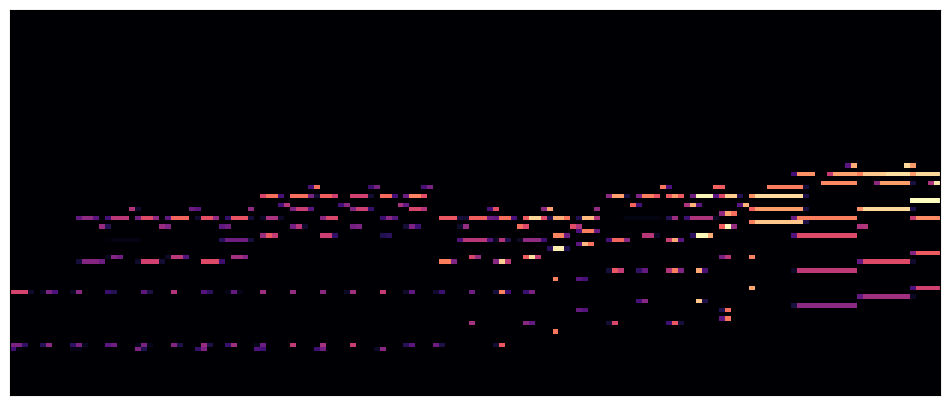

In [82]:
pb_i = p_rolls_bin[idx]
pr_i = p_rolls_raw[idx]
po_i = p_rolls_ons[idx]
cqt_i = cqts[idx]
y_i = audio[idx]

plt.figure(figsize=(12, 5))
librosa.display.specshow(cqt_i.T)
plt.show()
plt.figure(figsize=(12, 5))
librosa.display.specshow(pb_i.T + po_i.T)
plt.show()
plt.figure(figsize=(12, 5))
librosa.display.specshow(pr_i.T)
plt.show()

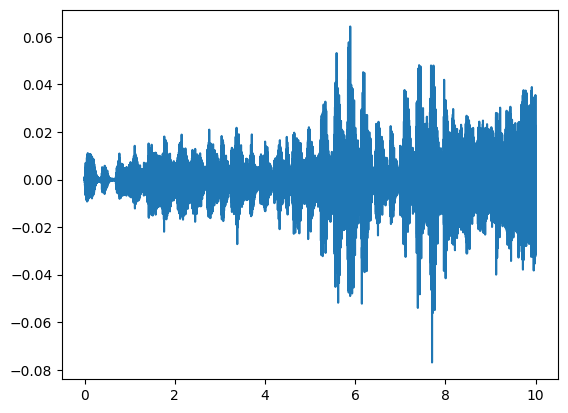

In [83]:
plt.plot(np.linspace(0, y_i.shape[0] / sr, y_i.shape[0]), y_i)

In [84]:
from IPython.display import Audio
Audio(y_i, rate=sr)

In [85]:
X_train, X_test, y_train, y_test, a_train, a_test = train_test_split(
    cqts, p_rolls_bin, audio, train_size=train_size, shuffle=False
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1016, 156, 168), (1016, 156, 88), (282, 156, 168), (282, 156, 88))

# Model

In [108]:
timesteps, specshape = cqts.shape[1:3]
notes_count = p_rolls_bin.shape[2]

In [113]:
# from keras import layers, models

# model1 = models.Sequential([
#     # Блок 1
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                   input_shape=(timesteps, specshape, 1), name='Conv2d__0'),
#     layers.BatchNormalization(name='Batch_Norm__0'),
#     layers.MaxPooling2D((1, 2), name='Max_Pool__0'),
#     # Блок 2
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                   input_shape=(timesteps, specshape, 1), name='Conv2d__1'),
#     layers.BatchNormalization(name='Batch_Norm__1'),
#     layers.MaxPooling2D((1, 4), name='Max_Pool__1'),
#     # Блок 3
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   name='Conv2d__2'),
#     layers.BatchNormalization(name='Batch_Norm__2'),
#     layers.MaxPooling2D((1, 4), name='Max_Pool__2'),
#     # Блок 4
#     layers.Conv2D(notes_count, (3, 3), activation='relu', padding='same',
#                   name='Conv2d__3'),
#     layers.BatchNormalization(name='Batch_Norm__3'),
#     layers.MaxPooling2D((1, 4), name='Max_Pool__3'),
#     layers.Dropout(0.2, name='Dropout'),
#     # Блок 5
#     layers.Conv2D(notes_count, (3, 3), activation='sigmoid', padding='same',
#                   name='Conv2d__4'),
#     layers.Reshape((timesteps, notes_count), name='Piano_Roll')
# ])
# model1.compile(optimizer='adam', loss='binary_crossentropy',
#                metrics=['mse', 'mae'])
# model1.summary()

In [155]:
from keras import layers, models

model1 = models.Sequential([
    # Блок 1
    layers.Conv2D(16, (3, 3), activation='selu', padding='same',
                  input_shape=(timesteps, specshape, 1), name='Conv2d__0'),
    layers.BatchNormalization(name='Batch_Norm__0'),
    layers.MaxPooling2D((1, 2), name='Max_Pool__0'),
    # Блок 2
    layers.Conv2D(32, (3, 3), activation='selu', padding='same',
                  input_shape=(timesteps, specshape, 1), name='Conv2d__1'),
    layers.BatchNormalization(name='Batch_Norm__1'),
    layers.MaxPooling2D((1, 4), name='Max_Pool__1'),
    # Блок 3
    layers.Conv2D(64, (3, 3), activation='selu', padding='same',
                  name='Conv2d__2'),
    layers.BatchNormalization(name='Batch_Norm__2'),
    layers.MaxPooling2D((1, 4), name='Max_Pool__2'),
    # Блок 4
    layers.Conv2D(notes_count, (3, 3), activation='sigmoid', padding='same',
                  name='Conv2d__3'),
    layers.BatchNormalization(name='Batch_Norm__3'),
    layers.MaxPooling2D((1, 4), name='Max_Pool__3'),
    layers.Dropout(0.2, name='Dropout'),
    # Блок 5
    layers.Conv2D(notes_count, (3, 3), activation='sigmoid', padding='same',
                  name='Conv2d__4'),
    layers.Reshape((timesteps, notes_count), name='Piano_Roll')
])
model1.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['mse', 'mae'])
model1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2d__0 (Conv2D)              │ (None, 156, 168, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm__0                   │ (None, 156, 168, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool__0 (MaxPooling2D)      │ (None, 156, 84, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d__1 (Conv2D)              │ (None, 156, 84, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm__1                   │ (None, 156, 84, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool__1 (MaxPooling2D)      │ (None, 156, 21, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d__2 (Conv2D)              │ (None, 156, 21, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm__2                   │ (None, 156, 21, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool__2 (MaxPooling2D)      │ (None, 156, 5, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d__3 (Conv2D)              │ (None, 156, 5, 88)     │        50,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm__3                   │ (None, 156, 5, 88)     │           352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool__3 (MaxPooling2D)      │ (None, 156, 1, 88)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 156, 1, 88)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d__4 (Conv2D)              │ (None, 156, 1, 88)     │        69,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Piano_Roll (Reshape)            │ (None, 156, 88)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,656 (565.06 KB)

 Trainable params: 144,256 (563.50 KB)

 Non-trainable params: 400 (1.56 KB)

In [156]:
model_layers = [layers.InputLayer((timesteps, specshape, 1),
                                  name='CQT_spec')] + model1.layers
print(len(model_layers))
model_layers

16


[<InputLayer name=CQT_spec, built=True>,
 <Conv2D name=Conv2d__0, built=True>,
 <BatchNormalization name=Batch_Norm__0, built=True>,
 <MaxPooling2D name=Max_Pool__0, built=True>,
 <Conv2D name=Conv2d__1, built=True>,
 <BatchNormalization name=Batch_Norm__1, built=True>,
 <MaxPooling2D name=Max_Pool__1, built=True>,
 <Conv2D name=Conv2d__2, built=True>,
 <BatchNormalization name=Batch_Norm__2, built=True>,
 <MaxPooling2D name=Max_Pool__2, built=True>,
 <Conv2D name=Conv2d__3, built=True>,
 <BatchNormalization name=Batch_Norm__3, built=True>,
 <MaxPooling2D name=Max_Pool__3, built=True>,
 <Dropout name=Dropout, built=True>,
 <Conv2D name=Conv2d__4, built=True>,
 <Reshape name=Piano_Roll, built=True>]

0: [156 168   1]
CQT spec (168, 1)
1: [156 168  16]
Conv2d (168, 16)
2: [156 168  16]
Batch Norm (168, 16)
3: [156  84  16]
Max Pool (84, 16)
4: [156  84  32]
Conv2d
(84, 32)
5: [156  84  32]
Batch Norm
(84, 32)
6: [156  21  32]
Max Pool
(21, 32)
7: [156  21  64]
Conv2d
(21, 64)
8: [156  21  64]
Batch Norm
(21, 64)
9: [156   5  64]
Max Pool
(5, 64)
10: [156   5  88]
Conv2d
(5, 88)
11: [156   5  88]
Batch Norm
(5, 88)
12: [156   1  88]
Max Pool
(1, 88)
13: [156   1  88]
Dropout
(1, 88)
14: [156   1  88]
Conv2d
(1, 88)
15: [156   1  88]
Piano Roll
(88,)


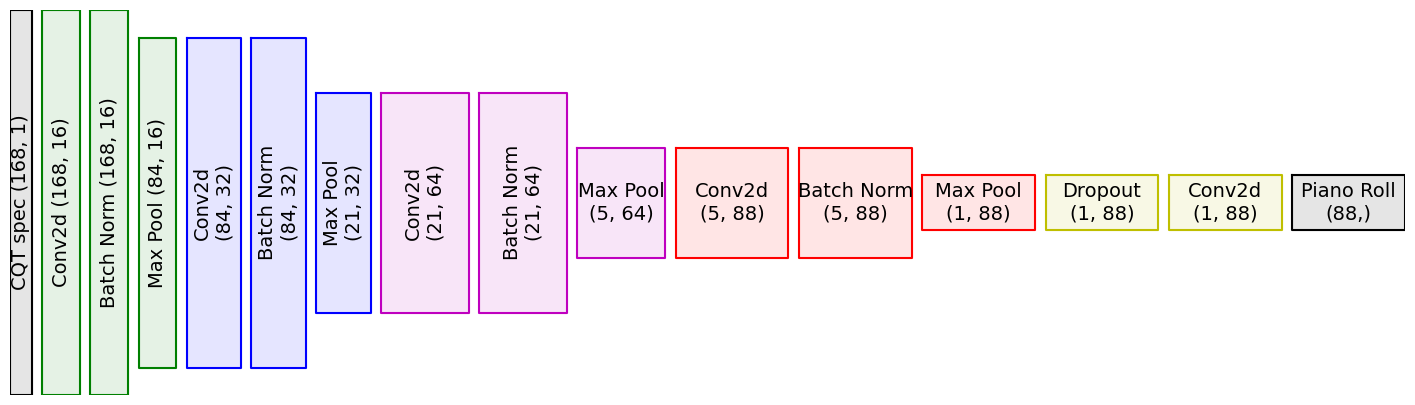

In [157]:
fig, ax = plt.subplots(figsize=(18, 5))
init_shape = [1, timesteps, specshape, 1]
current_layer = np.zeros(init_shape)

current_idx = 0
current_layer = np.zeros(init_shape)
colors = ['k', 'g', 'g', 'g', 'b', 'b', 'b', 'm', 'm', 'm', 'r', 'r', 'r', 'y', 'y', 'k', ]

for i, layer in enumerate(model_layers):
    if not layer.name.startswith('CQT_spec'):
        current_layer = layer(current_layer)
    layer_shape = current_layer.shape[1:]
    if len(layer_shape) == 2:
        shape = np.array((timesteps, 1, notes_count))
    else:
        shape = np.array(layer_shape)
    print(f'{i}: {shape}')
    shape += np.array([0, 1, 10]) * 2
    shape[1] = np.log2(np.float32(shape))[1]
    x = np.array([current_idx, current_idx + shape[-1]])
    y_val = shape[1]
    y = np.array([y_val, -y_val])
    f = np.array([x[[0, 1, 1, 0, 0]], y[[0, 0, 1, 1, 0]]])
    current_idx += shape[-1] + 10
    splitter = ' ' if (layer_shape[-1]) <= 16 else '\n'
    rot = 90 if layer_shape[1] > 10 and len(layer_shape) == 3 else 0
    layer_shape = f'{layer_shape[1:]}'
    annot = layer.name.split('__')[0].replace('_', ' ')
    annot += splitter + layer_shape
    print(annot)
    coords = ((f[0].max() + f[0].min()) / 2, 0)
    ax.annotate(annot, xy=coords, textcoords='data', rotation=rot, ha='center', va='center',
                fontsize=14)
    ax.plot(f[0], f[1], c=colors[i])
    ax.fill(f[0], f[1], c=colors[i], alpha=0.1)

plt.margins(0)
ax.set_axis_off()
fig.show()

In [ ]:
model1.fit(X_train, y_train, epochs=20, validation_split=0.2)

In [ ]:
pred = model1.predict(X_test)
loss, mae, mse = model1.evaluate(X_test, y_test)

In [ ]:
model1.fit(X_train, y_train, epochs=20, validation_split=0.2)

In [ ]:
pred = model1.predict(X_test)
loss, mae, mse = model1.evaluate(X_test, y_test)

In [171]:
model1.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - loss: 0.0920 - mae: 0.0505 - mse: 0.0257 - val_loss: 0.0861 - val_mae: 0.0486 - val_mse: 0.0239
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.0883 - mae: 0.0502 - mse: 0.0249 - val_loss: 0.0886 - val_mae: 0.0446 - val_mse: 0.0247
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.0900 - mae: 0.0509 - mse: 0.0253 - val_loss: 0.0859 - val_mae: 0.0525 - val_mse: 0.0242
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0874 - mae: 0.0497 - mse: 0.0246 - val_loss: 0.0897 - val_mae: 0.0462 - val_mse: 0.0253
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0875 - mae: 0.0494 - mse: 0.0247 - val_loss: 0.0880 - val_mae: 0.0491 - val_mse: 0.0246
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 0.0846 - mae: 0.0488 - mse: 0.0239 - val_loss: 0.0887 - val_mae: 0.0492 - val_mse: 0.0246
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - loss: 0.0866 - mae: 0.0499 - mse: 0.0244 - val_loss: 0.0870 

In [177]:
pred = model1.predict(X_test)
loss, mae, mse = model1.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 567ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - loss: 0.1069 - mae: 0.0580 - mse: 0.0292


In [178]:
# model.fit(X_train, y_train, epochs=20, validation_split=0.2)

In [179]:
# pred = model.predict(X_test)
# loss, mae, mse = model.evaluate(X_test, y_test)

In [183]:
df = pd.DataFrame({
    'loss (crossentropy)': loss, 'mae': mae, 'mse': mse
}, index=['Our CNN']).T
df

,Our CNN
loss (crossentropy),0.099454
mae,0.026972
mse,0.053784


In [176]:
mw_path = 'model.weights.h5'

In [146]:
model1.save_weights(mw_path)

In [159]:
model1.load_weights(mw_path)

In [ ]:
from google.colab import files
files.download(mw_path)

In [153]:
idx = np.random.randint(len(pred))

In [185]:
print(idx)

234


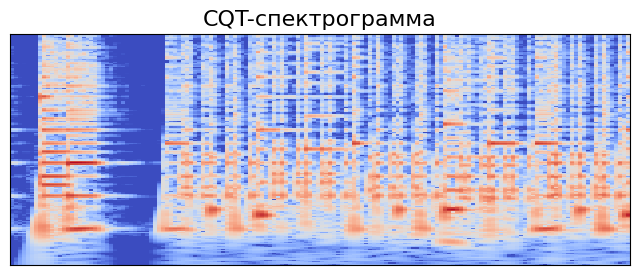

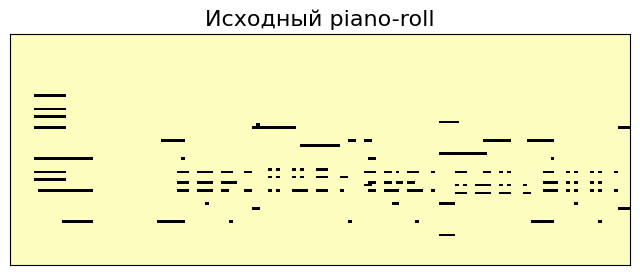

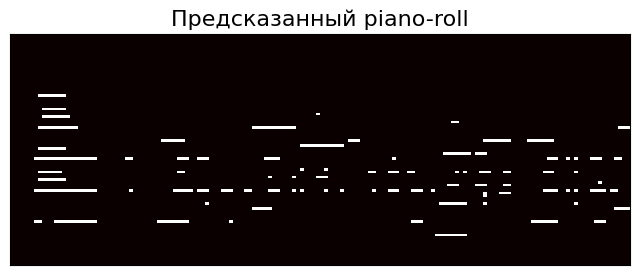

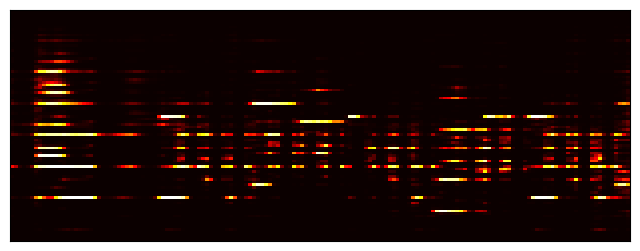

In [186]:
pb_i = y_test[idx]
pred_i = pred[idx]
cqt_i = X_test[idx]
y_i = a_test[idx]

plt.figure(figsize=(8, 3))
librosa.display.specshow(cqt_i.T)
plt.title('CQT-спектрограмма', size=16)
plt.show()
plt.figure(figsize=(8, 3))
librosa.display.specshow(1-pb_i.T)
plt.title('Исходный piano-roll', size=16)
plt.show()
# plt.figure(figsize=(12, 5))
# librosa.display.specshow(pb_i.T * cqt_i.T)
# plt.show()
plt.figure(figsize=(8, 3))
librosa.display.specshow((pred_i.T > 0.5), cmap='hot')
plt.title('Предсказанный piano-roll', size=16)
plt.show()
plt.figure(figsize=(8, 3))
librosa.display.specshow((pred_i.T), cmap='hot')
plt.show()
# plt.figure(figsize=(12, 5))
# librosa.display.specshow(np.int16(pred_i.T > 0.5) * cqt_i.T)
# plt.show()

In [187]:
cqt_i.shape

(156, 168)

In [188]:
# path = '/content/Исаак Дунаевский галоп Девушка спешит на свидание.mp3'
# path = '/content/turkish-march-mozart-rondo-alla-turca.mp3'
# path = '/content/Шёпот, робкое дыханье ре педаль.mp3'
# path = ''

In [189]:
# y_i = librosa.load(path, sr=sr)[0][:sr * 10]
# cqt_i = audio_to_cqt(y_i, sr, hop_length=hop_length).T[0, :156]
# pred_i = model.predict(np.array([cqt_i]))[0]

# plt.figure(figsize=(12, 5))
# librosa.display.specshow(cqt_i.T)
# plt.show()
# plt.figure(figsize=(12, 5))
# librosa.display.specshow((pred_i.T > 0.8), cmap='hot')
# plt.show()
# plt.figure(figsize=(12, 5))
# librosa.display.specshow((pred_i.T), cmap='hot')
# plt.show()
# # plt.figure(figsize=(12, 5))
# # librosa.display.specshow(np.int16(pred_i.T > 0.5) * cqt_i.T)
# # plt.show()

In [196]:
from IPython.display import Audio
import soundfile as sf; sf.write('synth_audio.mp3', y_i, sr)
Audio(y_i, rate=sr)

# Piano roll to midi

In [191]:
import pretty_midi
import numpy as np
import pandas as pd

# 1. PIANO ROLL → MIDI (основная функция)
def pianoroll_to_midi(pianoroll, fs=100, program=0, velocity=100, threshold=0.5):
    """
    Преобразует piano roll в объект PrettyMIDI.

    Args:
        pianoroll: numpy array формы (время_кадры, 88_нот)
        fs: частота кадров piano roll (кадров/сек)
        program: номер инструмента MIDI (0 = фортепиано)
        velocity: сила нажатия (0-127)
        threshold: порог активации ноты

    Returns:
        pretty_midi.PrettyMIDI объект
    """
    midi_data = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # Для каждой из 88 нот (от A0=21 до C8=108)
    for note_idx in range(pianoroll.shape[1]):
        note_activation = pianoroll[:, note_idx]
        activated = note_activation > threshold

        if not np.any(activated):
            continue

        # Находим начала и концы нот
        diff = np.diff(np.concatenate(([0], activated.astype(int), [0])))
        onsets = np.where(diff == 1)[0]
        offsets = np.where(diff == -1)[0]

        for onset, offset in zip(onsets, offsets):
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=21 + note_idx,  # MIDI номер ноты
                start=onset / fs,
                end=offset / fs
            )
            instrument.notes.append(note)

    midi_data.instruments.append(instrument)
    return midi_data

# 2. MIDI → НОТЫ (читаемый формат)
def midi_to_notes(midi_data, program=None):
    """
    Извлекает список нот из MIDI данных.

    Args:
        midi_data: путь к файлу или PrettyMIDI объект
        program: фильтр по инструменту (опционально)

    Returns:
        Список словарей с информацией о нотах
    """
    if isinstance(midi_data, str):
        midi_data = pretty_midi.PrettyMIDI(midi_data)

    notes = []
    for instrument in midi_data.instruments:
        if program is not None and instrument.program != program:
            continue

        for note in instrument.notes:
            notes.append({
                'pitch': note.pitch,
                'note_name': pretty_midi.note_number_to_name(note.pitch),
                'start': note.start,
                'end': note.end,
                'duration': note.end - note.start,
                'velocity': note.velocity,
                'program': instrument.program,
                'instrument': pretty_midi.program_to_instrument_name(instrument.program)
            })

    return sorted(notes, key=lambda x: x['start'])

# 3. НОТЫ → PIANO ROLL (обратное преобразование)
def notes_to_pianoroll(notes, fs=100, total_time=None):
    """
    Преобразует список нот обратно в piano roll.

    Args:
        notes: список словарей с информацией о нотах
        fs: частота кадров
        total_time: общая длительность (если None, вычисляется из нот)

    Returns:
        numpy array формы (время_кадры, 88)
    """
    if total_time is None:
        total_time = max(note['end'] for note in notes) if notes else 0

    num_frames = int(np.ceil(total_time * fs))
    pianoroll = np.zeros((num_frames, 88), dtype=np.float32)

    for note in notes:
        start_frame = int(note['start'] * fs)
        end_frame = int(note['end'] * fs)
        note_idx = note['pitch'] - 21  # Преобразуем MIDI pitch в индекс 0-87

        if 0 <= note_idx < 88:
            pianoroll[start_frame:end_frame, note_idx] = note.get('velocity', 100) / 127.0

    return pianoroll

# 4. РАСШИРЕННАЯ ФУНКЦИЯ: PIANO ROLL → MIDI с учетом velocity
def pianoroll_to_midi_with_velocity(pianoroll, fs=100, program=0, velocity_threshold=0.1):
    """
    Преобразует piano roll с значениями velocity в MIDI.

    Args:
        pianoroll: numpy array формы (время_кадры, 88) со значениями [0, 1]
        fs: частота кадров
        program: номер инструмента
        velocity_threshold: минимальное значение для активации ноты
    """
    midi_data = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    for note_idx in range(pianoroll.shape[1]):
        activation = pianoroll[:, note_idx]

        # Находим сегменты, где активация выше порога
        above_threshold = activation > velocity_threshold

        if not np.any(above_threshold):
            continue

        # Используем медианную фильтрацию для сглаживания
        from scipy.ndimage import binary_closing
        smoothed = binary_closing(above_threshold, structure=np.ones((3,)))

        # Находим начала и концы
        diff = np.diff(np.concatenate(([0], smoothed.astype(int), [0])))
        onsets = np.where(diff == 1)[0]
        offsets = np.where(diff == -1)[0]

        for onset, offset in zip(onsets, offsets):
            # Берем среднее значение velocity в сегменте
            segment_velocity = np.mean(activation[onset:offset])
            velocity = int(np.clip(segment_velocity * 127, 1, 127))

            note = pretty_midi.Note(
                velocity=velocity,
                pitch=21 + note_idx,
                start=onset / fs,
                end=offset / fs
            )
            instrument.notes.append(note)

    midi_data.instruments.append(instrument)
    return midi_data

# 5. ВИЗУАЛИЗАЦИЯ ДЛЯ СРАВНЕНИЯ
def visualize_pianoroll_comparison(original_roll, predicted_roll, fs=100, time_range=(0, 10)):
    """
    Визуализирует сравнение оригинального и предсказанного piano roll.
    """
    import matplotlib.pyplot as plt

    start_frame = int(time_range[0] * fs)
    end_frame = int(time_range[1] * fs)

    fig, axes = plt.subplots(2, 1, figsize=(12, 6))

    axes[0].imshow(original_roll[start_frame:end_frame].T,
                   aspect='auto', origin='lower', cmap='Reds')
    axes[0].set_title('Оригинальный Piano Roll')
    axes[0].set_ylabel('Ноты (0-87)')

    axes[1].imshow(predicted_roll[start_frame:end_frame].T,
                   aspect='auto', origin='lower', cmap='Blues')
    axes[1].set_title('Предсказанный Piano Roll')
    axes[1].set_xlabel('Временные кадры')
    axes[1].set_ylabel('Ноты (0-87)')

    plt.tight_layout()
    plt.show()

Создано 85 нот:
  Нота 1: C#2 (длительность: 0.13с)
  Нота 2: C#3 (длительность: 1.03с)
  Нота 3: C#4 (длительность: 1.03с)

Оригинальная форма: (156, 88)
Восстановленная форма: (156, 88)


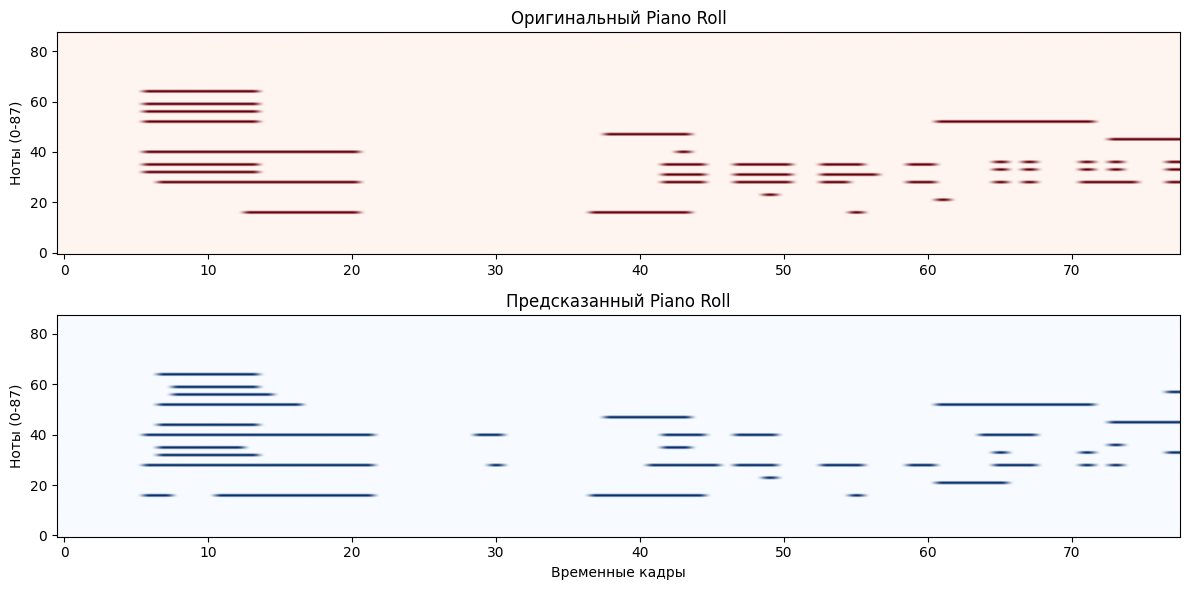

СТАТИСТИКА ПРЕДСКАЗАНИЙ:
Всего нот: 85
Диапазон высот: 32 - 85
Средняя длительность: 0.23с
Общая длительность: 10.00с

Самые частые ноты:
note_name
C#3    20
C#4    11
G#3    11
C#2     7
G#4     4
Name: count, dtype: int64


In [192]:
# ПРИМЕР 1: Полный цикл преобразований
# Допустим, у нас есть предсказание модели
predicted_pianoroll = np.int16(pred_i > 0.5)

fs = (pred_i.shape[0] / 10)

# 1. Преобразуем piano roll в MIDI
midi_obj = pianoroll_to_midi(predicted_pianoroll, fs=fs)

# 2. Сохраняем MIDI файл
midi_obj.write('model_output.mid')

# 3. Извлекаем ноты из созданного MIDI
notes = midi_to_notes(midi_obj)
print(f"Создано {len(notes)} нот:")
for i, note in enumerate(notes[:3]):
    print(f"  Нота {i+1}: {note['note_name']} (длительность: {note['duration']:.2f}с)")

# 4. Преобразуем обратно в piano roll для проверки
reconstructed_roll = notes_to_pianoroll(notes, fs=fs)
print(f"\nОригинальная форма: {predicted_pianoroll.shape}")
print(f"Восстановленная форма: {reconstructed_roll.shape}")

# ПРИМЕР 2: Сравнение с оригиналом (если есть ground truth)
# Загружаем оригинальный MIDI
# original_midi = pretty_midi.PrettyMIDI('original.mid')
original_midi = pianoroll_to_midi(pb_i, fs=fs)
original_midi.write('original.mid')
original_notes = midi_to_notes(original_midi)

# Преобразуем в piano roll с той же fs
original_roll = notes_to_pianoroll(original_notes, fs=fs)

# Визуализируем сравнение
visualize_pianoroll_comparison(original_roll, predicted_pianoroll,
                               fs=fs, time_range=(0, 5))

# ПРИМЕР 3: Анализ предсказаний модели в табличном виде
def analyze_predictions(predicted_roll, fs=fs):
    """Анализирует предсказания модели и возвращает статистику."""
    notes = midi_to_notes(pianoroll_to_midi(predicted_roll, fs=fs))

    if not notes:
        return None

    df = pd.DataFrame(notes)

    print("СТАТИСТИКА ПРЕДСКАЗАНИЙ:")
    print(f"Всего нот: {len(df)}")
    print(f"Диапазон высот: {df['pitch'].min()} - {df['pitch'].max()}")
    print(f"Средняя длительность: {df['duration'].mean():.2f}с")
    print(f"Общая длительность: {df['end'].max():.2f}с")

    # Группировка по высоте
    pitch_counts = df['note_name'].value_counts()
    print(f"\nСамые частые ноты:\n{pitch_counts.head()}")

    return df

# Запускаем анализ
stats_df = analyze_predictions(predicted_pianoroll, fs=fs)